# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

# Overview

Sparkify, is a Udacity dataset designed to be similar to dataflows expected from a big data music service such as Spotify or Pandora. It is a log of user activity, with demographic information, ratings, music browsing habits etc. The aim of the project is to analyse this data, and via the Pyspark library for python, apply machine learning models in an attempt to accurately predict CHURN (the likelihood of a customer ending the service).

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf, count
from pyspark.sql.types import IntegerType
from pyspark.sql import Window
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, GBTClassifier, LinearSVC, RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from time import time

In [2]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

# Load and Clean Dataset
Clean your dataset, checking for invalid or missing data. For example, records without userids or sessionids. In this workspace, the filename is `mini_sparkify_event_data.json`.

# Preprocessing walk through 
Load the data from json file.
Delete NAs.
Remove rows with empty as UserId.
Create CHURN column based on Cancellation Confirmation. 1 represents customer has churned, otherwise 0.

In [3]:
# Read in full sparkify dataset
sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)

In [15]:
# Take initial look at data
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [16]:
df.count()

286500

In [4]:
# Drop NA userids or sessionids
df = df.dropna(how = 'any', subset = ['userId', 'sessionId'])

In [18]:
# Examine userId column
df.select("userId").dropDuplicates().sort("userId").show(10)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
+------+
only showing top 10 rows



In [19]:
# Examine sessionId column
df.select("sessionId").dropDuplicates().sort("userId").show(10)

+---------+
|sessionId|
+---------+
|      656|
|     2088|
|      926|
|     1532|
|       54|
|      270|
|     1277|
|      293|
|     1217|
|     1409|
+---------+
only showing top 10 rows



There were instances of missing userids in the data represented as empty strings.  Since these missing values will not be useful for later analysis, these were dropped from the dataset by the following cell.

In [5]:
# drop empty strings
df = df.filter(df['userId'] != '')

In [21]:
# Check how many rows remain
df.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [12]:
# Convert to pandas dataframe and examine the contents
df_pd = df.toPandas()
df_pd.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [23]:
# look at the contents of the page features
df.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



There are 19 page activities that can be associated a user.  The Cancellation Confirmation value can be used to identify CHURN, and the other activities will be useful for feature engineering.

In [24]:
# Examine a user that had a Cancellation Confirmation
df.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates().show(10)

+------+
|userId|
+------+
|   125|
|    51|
|    54|
|100014|
|   101|
|    29|
|100021|
|    87|
|    73|
|     3|
+------+
only showing top 10 rows



In [6]:
# create churn label
churn_event = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn('churn_event', churn_event('page'))

# add label for users that churned
window = Window.partitionBy('userId')
df = df.withColumn('churn', max('churn_event').over(window))

In [26]:
# examine users including the added churn column
df.select(['userId', 'churn']).dropDuplicates().show(10)

+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
+------+-----+
only showing top 10 rows



In [27]:
df_songs = df.where(df.song!='null').groupby(['churn','userId']) \
    .agg(count(df.song).alias('SongsPlayed')).orderBy('churn').toPandas()

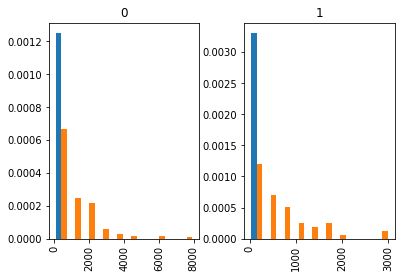

In [28]:
df_songs.hist(['SongsPlayed'], by='churn', density=1)
plt.plot();

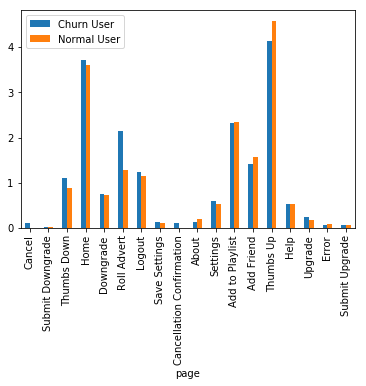

In [29]:
#Compare page use between churn and normal user
churn = df.filter(df.churn==1).count()
no_churn = df.filter(df.churn==0).count()

df1 = df.filter(df.churn==1).filter(df.page!="NextSong").groupby(["page"]).count()
df1 = df1.withColumn("Churn User", df1["count"]/(churn/100)).sort("page")

df2 = df.filter(df.churn==0).filter(df.page!="NextSong").groupby(["page"]).count()
df2 = df2.withColumn("Normal User", df2["count"]/(no_churn/100)).sort("page")

df_pd = df1.join(df2, "page", "outer").drop("count").fillna(0).toPandas()
df_pd.plot.bar("page");

There are a number of activities that look like they are strong indicators of potential CHURN.  The 'thumbs up' and 'thumbs down' values show distinct differences, and there is a strong indicator that CHURN customers roll adverts a lot.

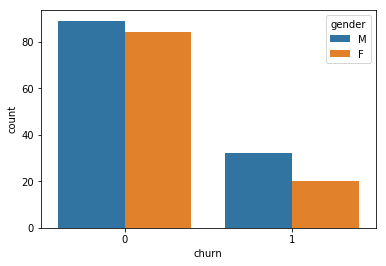

In [30]:
#Compare gender distribution between churn and normal user
df_gender_churn = df.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()

sns.barplot(x='churn', y='count', hue='gender', data=df_gender_churn)
plt.plot();

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [7]:
#total songs listened
feature1 = df.select('userID','song').groupBy('userID').count().withColumnRenamed('count', 'total_songs')

feature1.describe().show()

+-------+------------------+-----------------+
|summary|            userID|      total_songs|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|          1236.24|
| stddev|105396.47791907164|1329.531716432519|
|    min|                10|                6|
|    max|                99|             9632|
+-------+------------------+-----------------+



In [8]:
#Days since registration
feature2 = df.select('userId','registration','ts').withColumn('lifetime',(df.ts-df.registration)).groupBy('userId') \
             .agg({'lifetime':'max'}).withColumnRenamed('max(lifetime)','lifetime') \
             .select('userId', (col('lifetime')/1000/3600/24).alias('days_registered'))

feature2.describe().show()

+-------+------------------+-------------------+
|summary|            userId|    days_registered|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336|   79.8456834876543|
| stddev|105396.47791907164|  37.66147001861254|
|    min|                10|0.31372685185185184|
|    max|                99|  256.3776736111111|
+-------+------------------+-------------------+



In [9]:
# Songs added to playlist
feature3 = df.select('userID','page').where(df.page == 'Add to Playlist').groupBy('userID') \
             .count().withColumnRenamed('count', 'playlist_adds')

feature3.describe().show()

+-------+------------------+-----------------+
|summary|            userID|    playlist_adds|
+-------+------------------+-----------------+
|  count|               215|              215|
|   mean| 66103.63720930232|30.35348837209302|
| stddev|106360.47999565038| 32.8520568555997|
|    min|                10|                1|
|    max|                99|              240|
+-------+------------------+-----------------+



In [10]:
# Gender
feature4 = df.select("userId", "gender").dropDuplicates().replace(['M', 'F'], ['0', '1'], 'gender') \
             .select('userId', col('gender').cast('int'))
feature4.describe().show()

+-------+------------------+-------------------+
|summary|            userId|             gender|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336| 0.4622222222222222|
| stddev|105396.47791907165|0.49968243883744773|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



In [11]:
# Average songs per session
feature5 = df.where('page == "NextSong"').groupby(['userId', 'sessionId']).count().groupby(['userId']) \
             .agg({'count':'avg'}).withColumnRenamed('avg(count)', 'avg_songs_played')

feature5.describe().show()

+-------+------------------+-----------------+
|summary|            userId| avg_songs_played|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|70.78971233958933|
| stddev|105396.47791907164| 42.6153697543817|
|    min|                10|              3.0|
|    max|                99|286.6666666666667|
+-------+------------------+-----------------+



In [12]:
# Number of thumbs up
feature6 = df.select('userID','page').where(df.page == 'Thumbs Down').groupBy('userID') \
             .count().withColumnRenamed('count', 'thumbs_down')

feature6.describe().show()

+-------+------------------+------------------+
|summary|            userID|       thumbs_down|
+-------+------------------+------------------+
|  count|               203|               203|
|   mean| 66066.16256157635|12.541871921182265|
| stddev|106108.32569893777|13.198108566983787|
|    min|                10|                 1|
|    max|                99|                75|
+-------+------------------+------------------+



In [13]:
# Number of thumbs down
feature7 = df.select('userID','page').where(df.page == 'Thumbs Up').groupBy('userID') \
             .count().withColumnRenamed('count', 'thumbs_up')

feature7.describe().show()

+-------+------------------+-----------------+
|summary|            userID|        thumbs_up|
+-------+------------------+-----------------+
|  count|               220|              220|
|   mean| 66420.27727272727|            57.05|
| stddev|106196.51156121881|65.67028650524044|
|    min|                10|                1|
|    max|                99|              437|
+-------+------------------+-----------------+



In [14]:
# Number of artists heard
feature8 = df.filter(df.page=="NextSong").select("userId", "artist").dropDuplicates().groupby("userId") \
             .count().withColumnRenamed("count", "num_artists")

feature8.describe().show()

+-------+------------------+-----------------+
|summary|            userId|      num_artists|
+-------+------------------+-----------------+
|  count|               225|              225|
|   mean|65391.013333333336|696.3777777777777|
| stddev|105396.47791907164|603.9518698630802|
|    min|                10|                3|
|    max|                99|             3544|
+-------+------------------+-----------------+



In [15]:
# Number of help page visits
feature9 = df.select('userID','page').where(df.page == 'Help').groupBy('userID') \
             .agg({'page':'count'}).withColumnRenamed('count(page)', 'num_help')

feature9.describe().show()

+-------+------------------+-----------------+
|summary|            userID|         num_help|
+-------+------------------+-----------------+
|  count|               192|              192|
|   mean| 67244.30208333333|7.572916666666667|
| stddev|107862.22540637235|7.284416115934568|
|    min|                10|                1|
|    max|                99|               46|
+-------+------------------+-----------------+



In [16]:
# Number of friends added
feature10 = df.select('userID','page').where(df.page == 'Add Friend').groupBy('userID') \
              .agg({'page':'count'}) \
              .withColumnRenamed('count(page)', 'num_friend')

feature10.describe().show()

+-------+------------------+------------------+
|summary|            userID|        num_friend|
+-------+------------------+------------------+
|  count|               206|               206|
|   mean| 66076.91262135922|20.762135922330096|
| stddev|106860.60517425007|20.646779074405007|
|    min|                10|                 1|
|    max|                99|               143|
+-------+------------------+------------------+



In [17]:
# Churn label
churn = df.select('userId', col('churn').alias('label')).dropDuplicates()

churn.describe().show()

+-------+------------------+------------------+
|summary|            userId|             label|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|0.2311111111111111|
| stddev|105396.47791907164|0.4224832108996327|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



In [18]:
# Join all the features together
all_features = feature1.join(feature2,'userID','outer') \
                       .join(feature3,'userID','outer') \
                       .join(feature4,'userID','outer') \
                       .join(feature5,'userID','outer') \
                       .join(feature6,'userID','outer') \
                       .join(feature7,'userID','outer') \
                       .join(feature8,'userID','outer') \
                       .join(feature9,'userID','outer') \
                       .join(feature10,'userID','outer') \
                       .join(churn,'userID','outer') \
                       .drop('userID') \
                       .fillna(0)

I believe this 10 engineered features should be enough to enable a model to have a good chance of predicting CHURN. Too many more features may be counter productive.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [19]:
# Create a vector of the features
assembler = VectorAssembler(inputCols=all_features.columns[0:-1], outputCol="numfeatures")
df = assembler.transform(all_features)

In [20]:
# Normalise the data
scaler = StandardScaler(inputCol="numfeatures", outputCol="features", withStd=True)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

In [21]:
# train test split
train, rest = df.randomSplit([0.6, 0.4], seed=42)
validation, test = rest.randomSplit([0.5, 0.5], seed=42)

In [24]:
#Logistic Regression
log_regression = LogisticRegression()

lr_mclass_eval = MulticlassClassificationEvaluator(metricName='f1')

params = ParamGridBuilder().addGrid(log_regression.regParam,[0.0, 0.05]).build()

lr_cross_val = CrossValidator(estimator=log_regression,
                              estimatorParamMaps=params,
                              evaluator=lr_mclass_eval,
                              numFolds=3)

start = time()
lr_model = lr_cross_val.fit(train)
end = time()

print('Training time took {} seconds'.format(end - start))
print('F-1 Scores:')
lr_model.avgMetrics

Training time took 2417.766537427902 seconds
F-1 Scores:


[0.7357586781704911, 0.679558020152787]

In [22]:
# initialize classifier
random_forest = RandomForestClassifier()

# set evaluator
rf_mclass_eval = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
rf_params = ParamGridBuilder().addGrid(random_forest.impurity,['entropy', 'gini']) \
                              .addGrid(random_forest.maxDepth,[5, 10, 15]) \
                              .build()

rf_cross_val = CrossValidator(estimator=random_forest,
                              estimatorParamMaps=rf_params,
                              evaluator=rf_mclass_eval,
                              numFolds=3)

start = time()
rf_model = rf_cross_val.fit(train)
end = time()

print('Training time took {} seconds'.format(end - start))
print('F-1 Scores:')
rf_model.avgMetrics

Training time took 1755.1944425106049 seconds
F-1 Scores:


[0.7536129711809703,
 0.789699148217059,
 0.789699148217059,
 0.7853552440240483,
 0.7742318644796162,
 0.7742318644796162]

In [25]:
# initialize classifier
grad_boost = GBTClassifier()

# set evaluator
gb_mclass_eval = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
gb_params = ParamGridBuilder().addGrid(grad_boost.maxIter,[3, 10]) \
                              .addGrid(grad_boost.maxDepth,[4, 8]) \
                              .build()

gb_cross_val = CrossValidator(estimator=grad_boost,
                              estimatorParamMaps=gb_params,
                              evaluator=gb_mclass_eval,
                              numFolds=3)

start = time()
gb_model = gb_cross_val.fit(train)
end = time()

print('Training time took {} seconds'.format(end - start))
print('F-1 Scores:')
gb_model.avgMetrics

Training time took 3477.3616700172424 seconds
F-1 Scores:


[0.7641144926743912,
 0.7578059736946394,
 0.7554697976850642,
 0.7578059736946394]

In [23]:
# initialize classifier
svm = LinearSVC(maxIter=10, regParam=0.01)

# set evaluator
svm_mclass_eval = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
svm_params = ParamGridBuilder().addGrid(svm.regParam,[0.01, 0.05, 0.5]) \
                               .build()

svm_crossval = CrossValidator(estimator=svm,
                              estimatorParamMaps=svm_params,
                              evaluator=svm_mclass_eval,
                              numFolds=3)

start = time()
svm_model = svm_crossval.fit(train)
end = time()

print('Training time took {} seconds'.format(end - start))
print('F-1 Scores:')
svm_model.avgMetrics

Training time took 1919.7600197792053 seconds
F-1 Scores:


[0.6821891020813213, 0.6821891020813213, 0.6821891020813213]

In [28]:
# Run best model
rf_best = RandomForestClassifier(impurity='gini', maxDepth=5)
rf_model = rf_best.fit(train)
rf_results = rf_model.transform(validation)

# set evaluator
rf_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

print('Random Forest Metrics:')
print('Accuracy: {}'.format(rf_evaluator.evaluate(rf_results, {rf_evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(rf_evaluator.evaluate(rf_results, {rf_evaluator.metricName: "f1"})))

Random Forest Metrics:
Accuracy: 0.8235294117647058
F-1 Score:0.8079802550390786


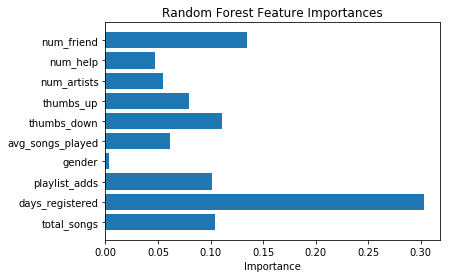

In [29]:
features_imp = rf_model.featureImportances.values
cols = all_features.columns[0:-1]
y_pos = np.arange(len(cols))
 
plt.barh(y_pos, features_imp, align='center')
plt.yticks(y_pos, cols)
plt.xlabel('Importance')
plt.title('Random Forest Feature Importances');

The 'gender' feature was surprised in that it was of such little importance to the model, despite the earlier analysis that implied it may be useful.  Days_registered appears to be the strongest indicator of CHURN.